In [1]:
# Dependencies
import numpy as np
import pandas as pd

In [2]:
from sqlalchemy import create_engine
from hold import connection_string

In [3]:
engine = create_engine(f'{connection_string}', encoding='iso-8859-1', connect_args={'connect_timeout': 10})

In [4]:
gtdDF = pd.read_sql_table('global_terrorism', con= engine)

In [5]:
gtdDF.head()

,iyear,imonth,iday,date,country_txt,region_txt,provstate,city,latitude,longitude,...,claimmode_txt,weaptype1_txt,weapsubtype1_txt,weaptype2_txt,weapsubtype2_txt,kidhijcountry,ransom,nkill,nwound,index1
0,2000,1,1,2000-01-01,Namibia,Sub-Saharan Africa,Kavango,Muitjiku,-17.91,19.99,...,None,Firearms,Unknown Gun Type,None,None,None,NaN,0.0,7.0,1.0
1,2000,1,1,2000-01-01,Namibia,Sub-Saharan Africa,Kavango,Muitjiku,-17.91,19.99,...,None,Firearms,Unknown Gun Type,None,None,None,0.0,0.0,7.0,2.0
2,2000,1,1,2000-01-01,India,South Asia,Jammu and Kashmir,Udhampur,32.93,75.14,...,None,Firearms,Unknown Gun Type,None,None,None,NaN,1.0,2.0,3.0
3,2000,1,1,2000-01-01,Kosovo,Eastern Europe,Kosovo (Province),Peje,42.66,20.31,...,None,Explosives/Bombs/Dynamite,Unknown Explosive Type,None,None,None,NaN,0.0,1.0,4.0
4,2000,1,1,2000-01-01,Somalia,Sub-Saharan Africa,Banaadir,Mogadishu,2.11,45.39,...,None,Firearms,Unknown Gun Type,None,None,None,NaN,6.0,10.0,5.0


In [6]:
casualties = gtdDF['nkill'] + gtdDF['nwound']
casualties.sum()

554384.0

In [7]:
gtdDF['casualties'] = gtdDF['nkill'] + gtdDF['nwound']
gtdDF.head()

,iyear,imonth,iday,date,country_txt,region_txt,provstate,city,latitude,longitude,...,weaptype1_txt,weapsubtype1_txt,weaptype2_txt,weapsubtype2_txt,kidhijcountry,ransom,nkill,nwound,index1,casualties
0,2000,1,1,2000-01-01,Namibia,Sub-Saharan Africa,Kavango,Muitjiku,-17.91,19.99,...,Firearms,Unknown Gun Type,None,None,None,NaN,0.0,7.0,1.0,7.0
1,2000,1,1,2000-01-01,Namibia,Sub-Saharan Africa,Kavango,Muitjiku,-17.91,19.99,...,Firearms,Unknown Gun Type,None,None,None,0.0,0.0,7.0,2.0,7.0
2,2000,1,1,2000-01-01,India,South Asia,Jammu and Kashmir,Udhampur,32.93,75.14,...,Firearms,Unknown Gun Type,None,None,None,NaN,1.0,2.0,3.0,3.0
3,2000,1,1,2000-01-01,Kosovo,Eastern Europe,Kosovo (Province),Peje,42.66,20.31,...,Explosives/Bombs/Dynamite,Unknown Explosive Type,None,None,None,NaN,0.0,1.0,4.0,1.0
4,2000,1,1,2000-01-01,Somalia,Sub-Saharan Africa,Banaadir,Mogadishu,2.11,45.39,...,Firearms,Unknown Gun Type,None,None,None,NaN,6.0,10.0,5.0,16.0


In [8]:
CountryCasualtiesDF = gtdDF[['index1','country_txt','casualties']]
CountryCasualtiesDF = CountryCasualtiesDF.reset_index()
CountryCasualtiesDF.head()

,index,index1,country_txt,casualties
0,0,1.0,Namibia,7.0
1,1,2.0,Namibia,7.0
2,2,3.0,India,3.0
3,3,4.0,Kosovo,1.0
4,4,5.0,Somalia,16.0


In [9]:
# Group countries by casualties
CountryCasualtiesGroupDF = CountryCasualtiesDF.groupby(['country_txt']).count()
CountryCasualtiesGroupDF = CountryCasualtiesGroupDF.reset_index()
CountryCasualtiesGroupDF = CountryCasualtiesGroupDF.rename(columns = {'index1':'Casualties'})
CountryCasualtiesGroupDF = CountryCasualtiesGroupDF.sort_values(by='Casualties', ascending = False)
CountryCasualtiesGroupDF.head()

,country_txt,index,Casualties,casualties
67,Iraq,20729,20729,20729
108,Pakistan,11443,11443,11443
0,Afghanistan,10450,10450,10450
63,India,7594,7594,7594
112,Philippines,4061,4061,4061


In [10]:
# Filter countries by removing those with count = 1
CountryCasualtiesFilterDF = CountryCasualtiesGroupDF.loc[(CountryCasualtiesGroupDF['Casualties'] >= 2)]
CountryCasualtiesFilterDF.head()

,country_txt,index,Casualties,casualties
67,Iraq,20729,20729,20729
108,Pakistan,11443,11443,11443
0,Afghanistan,10450,10450,10450
63,India,7594,7594,7594
112,Philippines,4061,4061,4061


In [11]:
# Here filter countries
# This is needed to fix error with training data not in testing
filterList = ['Western Sahara','Costa Rica','Malawi','Equatorial Guinea','Gambia','Cuba','Togo','Romania',
             'Bahamas','St. Lucia','Slovenia','International']
CountryCasualtiesFilterDF = CountryCasualtiesDF[~CountryCasualtiesDF['country_txt'].isin(filterList)]
CountryCasualtiesFilterDF.head()

,index,index1,country_txt,casualties
0,0,1.0,Namibia,7.0
1,1,2.0,Namibia,7.0
2,2,3.0,India,3.0
3,3,4.0,Kosovo,1.0
4,4,5.0,Somalia,16.0


In [12]:
# Multiply the dummies by the casualties so that the regression works for casualties
CountryCasualties2DF = pd.get_dummies(CountryCasualtiesFilterDF['country_txt']).mul(CountryCasualtiesFilterDF['casualties'],0)
CountryCasualties2DF = CountryCasualties2DF.reset_index()
CountryCasualties2DF.head()

,index,Afghanistan,Albania,Algeria,Angola,Argentina,Armenia,Australia,Austria,Azerbaijan,...,United States,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza Strip,Yemen,Yugoslavia,Zambia,Zimbabwe
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
CountryCasualtiesMergeDF = result = pd.merge(CountryCasualties2DF,CountryCasualtiesFilterDF[['index','country_txt','casualties']],on='index')
CountryCasualtiesMergeDF.head()

,index,Afghanistan,Albania,Algeria,Angola,Argentina,Armenia,Australia,Austria,Azerbaijan,...,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza Strip,Yemen,Yugoslavia,Zambia,Zimbabwe,country_txt,casualties
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Namibia,7.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Namibia,7.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,India,3.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Kosovo,1.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Somalia,16.0


In [14]:
# Assign X (data) and y (target)
X = CountryCasualtiesMergeDF.drop(["index","casualties","country_txt"], axis=1)
y = CountryCasualtiesMergeDF["country_txt"]
feature_names = X.columns
print(X.shape, y.shape)

(92688, 152) (92688,)


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1, stratify=y)
X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

# Step 2: Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

C:\Users\kruiz\Anaconda3\envs\PythonData\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [16]:
from keras.models import Sequential
from keras.layers import Dense

# Create model and add layers
model = Sequential()
model.add(Dense(units=128, activation='relu', input_dim=152))
model.add(Dense(units=128, activation='relu'))
# Below value should be number of variables
model.add(Dense(units=152, activation='softmax'))

In [17]:
# Compile and fit the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=20,
    shuffle=True,
    verbose=2
)

Epoch 1/20
 - 8s - loss: 1.3789 - acc: 0.6872
Epoch 2/20
 - 7s - loss: 1.1203 - acc: 0.7231
Epoch 3/20
 - 8s - loss: 1.1071 - acc: 0.7231
Epoch 4/20
 - 8s - loss: 1.1001 - acc: 0.7243
Epoch 5/20
 - 8s - loss: 1.0959 - acc: 0.7242
Epoch 6/20
 - 8s - loss: 1.0915 - acc: 0.7245
Epoch 7/20
 - 7s - loss: 1.0868 - acc: 0.7259
Epoch 8/20
 - 8s - loss: 1.0835 - acc: 0.7282
Epoch 9/20
 - 8s - loss: 1.0819 - acc: 0.7293
Epoch 10/20
 - 8s - loss: 1.0808 - acc: 0.7297
Epoch 11/20
 - 8s - loss: 1.0793 - acc: 0.7299
Epoch 12/20
 - 8s - loss: 1.0796 - acc: 0.7298
Epoch 13/20
 - 8s - loss: 1.0782 - acc: 0.7298
Epoch 14/20
 - 8s - loss: 1.0781 - acc: 0.7302
Epoch 15/20
 - 8s - loss: 1.0780 - acc: 0.7302
Epoch 16/20
 - 8s - loss: 1.0775 - acc: 0.7302
Epoch 17/20
 - 8s - loss: 1.0775 - acc: 0.7299
Epoch 18/20
 - 8s - loss: 1.0775 - acc: 0.7302
Epoch 19/20
 - 7s - loss: 1.0792 - acc: 0.7297
Epoch 20/20
 - 8s - loss: 1.0818 - acc: 0.7298


In [18]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

Normal Neural Network - Loss: 1.1131215764310267, Accuracy: 0.7223804591748663


In [19]:
encoded_predictions = model.predict_classes(X_test_scaled[:12])
prediction_labels = label_encoder.inverse_transform(encoded_predictions)

C:\Users\kruiz\Anaconda3\envs\PythonData\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [20]:
print(f"Predicted classes: {prediction_labels}")
print(f"Actual Labels: {list(y_test[:20])}")

Predicted classes: ['Yemen' 'Iraq' 'Afghanistan' 'Afghanistan' 'Pakistan' 'Pakistan' 'Iraq'
 'Turkey' 'Pakistan' 'Iraq' 'Pakistan' 'Pakistan']
Actual Labels: ['Yemen', 'Iraq', 'Afghanistan', 'Afghanistan', 'Philippines', 'Pakistan', 'Iraq', 'Turkey', 'Pakistan', 'Iraq', 'Colombia', 'Pakistan', 'Nigeria', 'India', 'Nigeria', 'Iraq', 'Iraq', 'Pakistan', 'India', 'Ivory Coast']


In [21]:
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
model = XGBClassifier()
model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [22]:
sorted(zip(model.feature_importances_, feature_names), reverse=True)

[(0.081978984, 'Philippines'),
 (0.07353422, 'Thailand'),
 (0.06664306, 'India'),
 (0.06288984, 'Somalia'),
 (0.059553582, 'Yemen'),
 (0.058209915, 'Nigeria'),
 (0.042663153, 'Russia'),
 (0.038141686, 'Libya'),
 (0.037679452, 'Colombia'),
 (0.037655886, 'Egypt'),
 (0.036573153, 'Algeria'),
 (0.035536487, 'Turkey'),
 (0.035372175, 'Pakistan'),
 (0.03529713, 'Iraq'),
 (0.0338816, 'Afghanistan'),
 (0.03282394, 'Syria'),
 (0.024211051, 'West Bank and Gaza Strip'),
 (0.023485735, 'Ukraine'),
 (0.021656554, 'Sri Lanka'),
 (0.017795723, 'Bangladesh'),
 (0.016954422, 'Israel'),
 (0.013930997, 'Sudan'),
 (0.013203147, 'Nepal'),
 (0.011066144, 'Democratic Republic of the Congo'),
 (0.010268933, 'Kenya'),
 (0.009166358, 'Lebanon'),
 (0.008227838, 'Indonesia'),
 (0.00789335, 'Burundi'),
 (0.007470252, 'Mali'),
 (0.0057740663, 'Saudi Arabia'),
 (0.0055059996, 'United Kingdom'),
 (0.0038505322, 'Central African Republic'),
 (0.0034457527, 'Cameroon'),
 (0.0032233219, 'Uganda'),
 (0.00318373, 'China'

In [23]:
DLCountryCasualtiesDF = pd.DataFrame(sorted(zip(model.feature_importances_, feature_names), reverse=True), 
                               columns = ['Probability', 'Country'])
DLCountryCasualtiesDF.head()

,Probability,Country
0,0.081979,Philippines
1,0.073534,Thailand
2,0.066643,India
3,0.062890,Somalia
4,0.059554,Yemen


In [24]:
pies = DLCountryCasualtiesDF['Country'].head(15)
pie_slices = DLCountryCasualtiesDF['Probability'].head(15)
colors = ["lightskyblue","orange","pink","yellowgreen","lightcoral","silver","yellow",
          "lightgreen","wheat","khaki",
          "lightskyblue","orange","pink","yellowgreen","lightcoral"]
explode = (0.1,0,0,0,0,0,0,0,0,0
          ,0,0,0,0,0)

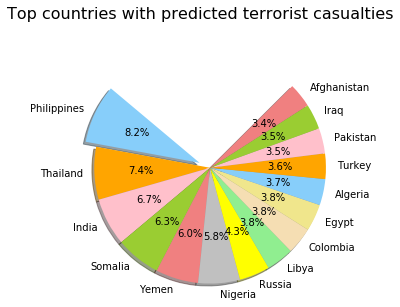

In [25]:
# Tell matplotlib to create a pie chart based upon the above data
pyplot.pie(pie_slices, explode=explode, labels=pies, colors=colors, 
        autopct="%1.1f%%", shadow=True, startangle=140)
# Create axes which are equal so we have a perfect circle
pyplot.axis("equal")
# Save an image of our chart and print the final product to the screen

pyplot.savefig("../GTA/front_end/static/front_end/assets/visualizations/ML18_Country_Casualties_Pie_DL")
pyplot.suptitle('Top countries with predicted terrorist casualties', size=16, y=1.12) 
pyplot.show()

In [26]:
DLTop15CountryCasualtiesDF = DLCountryCasualtiesDF.head(15)
DLTop15CountryCasualtiesDF

,Probability,Country
0,0.081979,Philippines
1,0.073534,Thailand
2,0.066643,India
3,0.062890,Somalia
4,0.059554,Yemen
5,0.058210,Nigeria
6,0.042663,Russia
7,0.038142,Libya
8,0.037679,Colombia
9,0.037656,Egypt


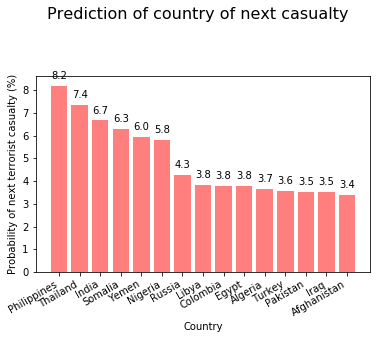

In [27]:
y_axis = DLTop15CountryCasualtiesDF['Probability']*100
x_axis = DLTop15CountryCasualtiesDF['Country']
fig, ax = pyplot.subplots()
# plot
ax.bar(x_axis, y_axis, color='r', alpha=0.5, align="center")

# Make space for and rotate the x-axis tick labels
fig.autofmt_xdate()

# Labels for x and y axes
pyplot.xlabel("Country")
pyplot.ylabel("Probability of next terrorist casualty (%)")

# Show the values of each probability on plot
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.
    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

# Call the function above. All the magic happens there.
add_value_labels(ax)

# Save an image of our chart and print the final product to the screen
pyplot.savefig("../GTA/front_end/static/front_end/assets/visualizations/ML18_Country_Casualties_Bar_DL")
# Title for the chart
pyplot.suptitle('Prediction of country of next casualty', size=16, y=1.12) 
pyplot.show()
